In [2]:
%load_ext autoreload

%autoreload 2

In [4]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from validation.metrics import OME
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

In [35]:
data = pd.read_excel('Data/full_data_2021-11-08.xlsx')
cols = ['Mw', 'Temperature', 'Shear_Rate','Melt_Viscosity']
for c in data.columns:
    if 'afp' in c or 'bfp' in c or 'mpf' in c or 'efp' in c:
        cols.append(c)

In [36]:
for c in ['Mw', 'Melt_Viscosity']:
    data[c] = np.log10(data[c])

for i in data.index:
    if data.loc[i, 'Shear_Rate'] != 0:
        data.loc[i,'Shear_Rate'] = np.log10(data.loc[i, 'Shear_Rate'])
        #data = data.drop([i])

In [83]:
#cols.remove('Shear_Rate')
filtered_data = data.loc[:, cols].dropna()
X_tot = np.array(filtered_data.filter([c for c in cols if 'afp' in c or 'bfp' in c or 'mpf' in c or 'efp' in c]))
tot_samples = X_tot.shape[0]
Y_tot = np.array(filtered_data.loc[:,'Melt_Viscosity']).reshape((tot_samples,1))

In [84]:
logMw = np.array(filtered_data['Mw']).reshape((tot_samples,1))
log_shear = np.array(filtered_data['Shear_Rate']).reshape((tot_samples,1))
Temp = np.array(filtered_data['Temperature']).reshape((tot_samples,1))
#scaler = MinMaxScaler(copy = False)
#scaler.fit(Y_tot).transform(Y_tot);
#scaler.fit(log_shear).transform(log_shear);
#scaler.fit(Temp).transform(Temp);


In [85]:
XX, X_test, yy, y_test, M, M_test, S, S_test, T, T_test = train_test_split(X_tot, Y_tot, logMw, log_shear, Temp, test_size=0.10)
#XX, X_test, yy, y_test = train_test_split(X_tot, Y_tot, test_size=0.10)

In [93]:
def create_model(n_features):
    fp_in = tf.keras.Input(shape=(n_features,))
    logMw = tf.keras.Input(shape=(1,))
    log_shear = tf.keras.Input(shape=(1,))
    T = tf.keras.Input(shape=(1,))
    layer_1 = Dense(100, activation='relu', kernel_initializer='he_normal')(fp_in)
    layer_2 = Dense(50, activation='relu', kernel_initializer='he_normal')(layer_1)
    params_layer = Dense(5, activation='relu')(layer_2)
    A,a,B,To,n = tf.keras.layers.Lambda(lambda x: tf.split(x,[1,1,1,1,1],axis=-1))(params_layer)
    log_eta = tf.keras.layers.Lambda(lambda x: x[0] + x[1]*x[5] + x[4]*x[6] + (x[2]/(x[7] - x[3])))([A,a,B,To,n, logMw, log_shear, T])
    model=tf.keras.models.Model(inputs=[fp_in, logMw, log_shear, T], outputs=[log_eta])
    model.compile(optimizer='adam', loss='mse')
    return model

In [97]:
def create_model(n_features):
    fp_in = tf.keras.Input(shape=(n_features,))
    layer_1 = Dense(100, activation='relu', kernel_initializer='he_normal')(fp_in)
    layer_2 = Dense(50, activation='relu', kernel_initializer='he_normal')(layer_1)
    params_layer = Dense(5, activation='relu')(layer_2)
    log_eta = Dense(1, activation = 'relu')(params_layer)
    model=tf.keras.models.Model(inputs=[fp_in, logMw, log_shear, T], outputs=[log_eta])
    model.compile(optimizer='adam', loss='mse')
    return model

In [94]:
kf = KFold(n_splits=5, shuffle = True)
m = []
error = []
bad = []
for train_index, test_index in kf.split(XX):
    X_train, X_val = XX[train_index], XX[test_index]
    y_train, y_val = yy[train_index], yy[test_index]
    M_train, M_val = M[train_index], M[test_index]
    S_train, S_val = S[train_index], S[test_index]
    T_train, T_val = T[train_index], T[test_index]
    n_features = X_train.shape[1]
    m.append(create_model(n_features))
    #model = create_model(n_features)
    m[-1].fit([X_train, M_train, S_train, T_train], y_train, epochs=300, batch_size=30, verbose=0)
    error.append(m[-1].evaluate([X_val, M_val, S_val, T_val], y_val, verbose=0))
    if error[-1] > 10:
        bad.append(train_index)
    print('MSE: %.3f, RMSE: %.3f' % (error[-1], np.sqrt(error[-1])))

MSE: 2.073, RMSE: 1.440
MSE: 1.693, RMSE: 1.301
MSE: 2.071, RMSE: 1.439
MSE: 1.117, RMSE: 1.057
MSE: 2.293, RMSE: 1.514


In [95]:
model = m[error.index(min(error))]

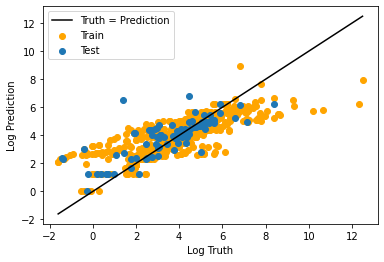

In [96]:
plt.scatter(y_train, model.predict([X_train, M_train, S_train, T_train]), c = 'orange')
plt.scatter(y_test,  model.predict([X_test, M_test, S_test, T_test]))
#plt.scatter(scaler.inverse_transform(y_train), scaler.inverse_transform(model.predict([X_train, M_train, S_train, T_train])), c = 'orange')
#plt.scatter(scaler.inverse_transform(y_test),  scaler.inverse_transform(model.predict([X_test, M_test, S_test, T_test])))
plt.plot(np.linspace((min(y_train)[0]), (max(y_train)[0]), num = 2),np.linspace((min(y_train)[0]), (max(y_train)[0]), num = 2),'k-')
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.legend(['Truth = Prediction','Train','Test'])
#rmse = metrics.RMSE(mean, yy)
#mape = metrics.MAPE(mean, yy)

In [88]:
print(model.summary())

Model: "model_79"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_321 (InputLayer)          [(None, 162)]        0                                            
__________________________________________________________________________________________________
dense_240 (Dense)               (None, 64)           10432       input_321[0][0]                  
__________________________________________________________________________________________________
dense_241 (Dense)               (None, 32)           2080        dense_240[0][0]                  
__________________________________________________________________________________________________
dense_242 (Dense)               (None, 5)            165         dense_241[0][0]                  
___________________________________________________________________________________________

In [ ]:
keras.plot_model